## Pythonによる画像解析実例 #1: 対象の形態の計測
230126のImageJ/FIJIのランチョンセミナーで紹介した、画像解析例をPythonで再現してみる  
具体的にはサンプル画像「embryo.tif」中の胞胚を検出して、形態の各種パラメータを計測  
file:///Users/masak_takaine/Dropbox/ImageJ_programming/230126_ImageJ_luncheon_MT/comment1.html

In [107]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io, img_as_float, img_as_ubyte
import imageio
from PIL import Image as pilimage
from IPython.display import display, Image
# Jupyter notebookの中で画像を表示させるための関数、読み込んだ画像が16-bitならば画像を8bitに変換するように修正
def show(img_grey):
    if img_grey.dtype == "uint16":
        img_grey = cv2.normalize(img_grey, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    _, buf = cv2.imencode(".jpg", img_grey)
    print(type(buf))
    print(buf.shape)
    display(Image(data = buf.tobytes()))

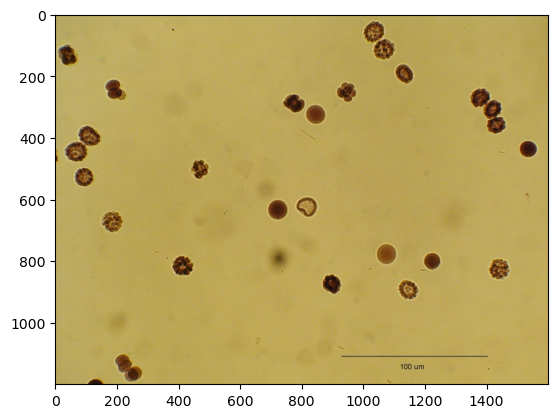

In [108]:
embryo = io.imread("images/embryos.tif")
plt.imshow(embryo)

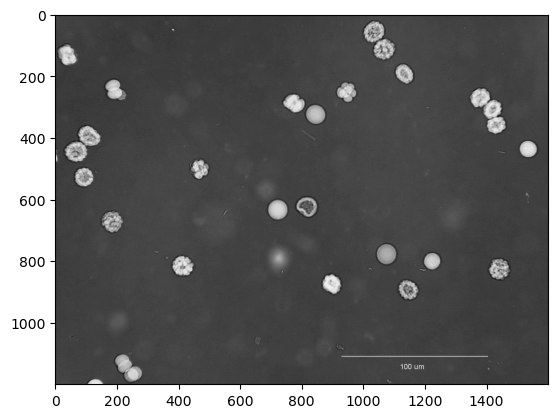

In [109]:
# グレースケールに変換して、白黒反転
from skimage.color import rgb2gray
from skimage.util import invert
gray = img_as_ubyte(rgb2gray(embryo)) # グレースケールへの変換で小数点型になるのでuint8型に戻す
gray = invert(gray)# 白黒反転
# gray = ~gray # 白黒反転
plt.imshow(gray, cmap = "gray")

In [110]:
# 背景の除去
from cv2_rolling_ball import subtract_background_rolling_ball
radius = 35
gray_bg, background = subtract_background_rolling_ball(gray, radius, light_background=False,
                                     use_paraboloid=False, do_presmooth=False)

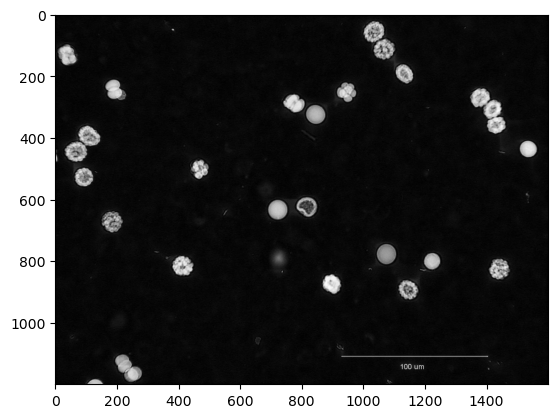

In [111]:
plt.imshow(gray_bg, cmap = "gray")

threshlold: 66


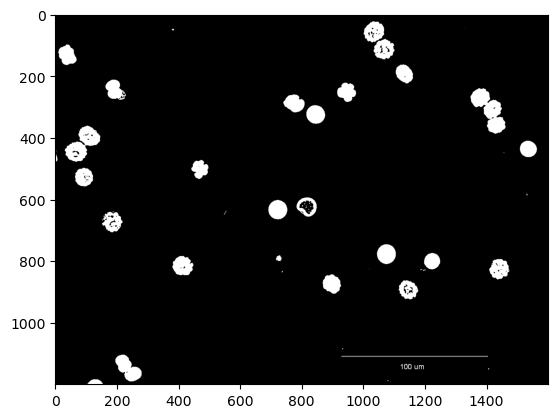

In [112]:
# 2値画像への変換
from skimage.filters import threshold_isodata
thresh = threshold_isodata(gray_bg)  # ImageJ/FIJIのDefaultのauto-thresholdingはISODATAの1種
print("threshlold:", thresh)
binary = img_as_ubyte(gray_bg > thresh)
plt.imshow(binary, cmap = "gray")

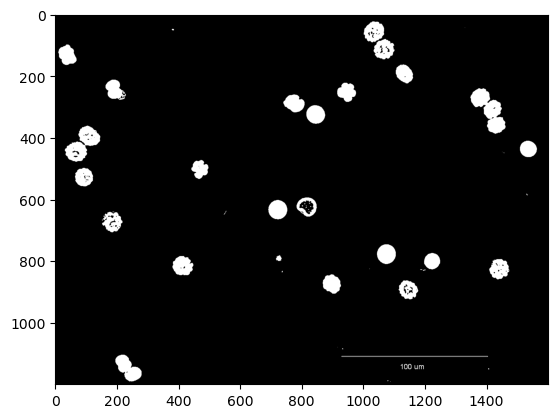

In [113]:
# 画面の端（境界）に接している対象を除くことができる
# 後述するcv2.connectedComponents()関数では境界に接している対象はラベルされないので、  
# この操作をしなくても結果には影響しない
from skimage.segmentation import clear_border
binary = clear_border(binary)
plt.imshow(binary, cmap = "gray")

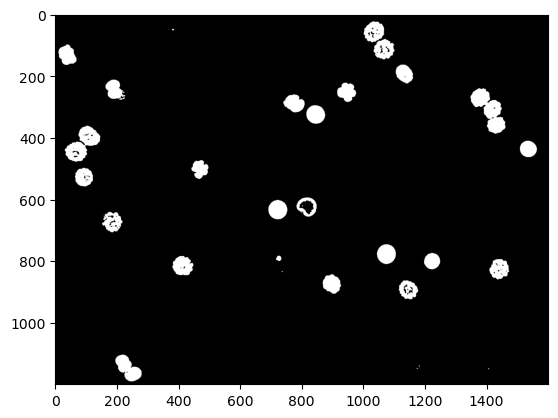

In [114]:
# フィルタ処理による分節化の最適化、opening -> Fill holes -> Watershed
from skimage.morphology import binary_opening
footprint = np.ones((3, 3))  # おそらくImageJにおけるopeningのカーネルは3x3
opening = binary_opening(binary, footprint= footprint)
plt.imshow(opening, cmap = "gray")

dtype('uint8')

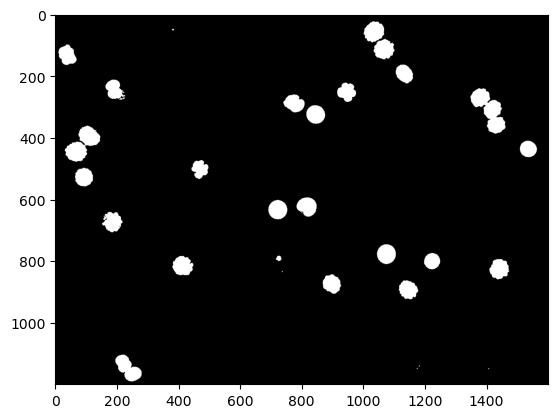

In [115]:
# Filling holes
from scipy import ndimage
filled = ndimage.binary_fill_holes(opening).astype(np.uint8)*255
plt.imshow(filled, cmap = "gray")
filled.dtype

Fill holesまでを関数化  
inputは画像ファイルのpath、rolling ballのradius、　　戻り値は穴埋めされた2値画像

In [116]:
from skimage.color import rgb2gray
from skimage.util import invert
from cv2_rolling_ball import subtract_background_rolling_ball
from skimage.filters import threshold_isodata
from skimage.morphology import binary_opening
from scipy import ndimage

# path = "images/embryos.tif"
# radius = 35
def preprocess(path, radius):
    img = io.imread(path)
    gray = img_as_ubyte(rgb2gray(img)) # グレースケールへの変換で小数点型になるのでuint8型に戻す
    gray = invert(gray)# 白黒反転
    gray_bg, background = subtract_background_rolling_ball(gray, radius, light_background=False,
                                         use_paraboloid=False, do_presmooth=False)
    thresh = threshold_isodata(gray_bg)
    binary = img_as_ubyte(gray_bg > thresh)
    binary = clear_border(binary)
    footprint = np.ones((3, 3))
    opening = binary_opening(binary, footprint= footprint)
    filled = ndimage.binary_fill_holes(opening).astype(np.uint8)*255
    return filled

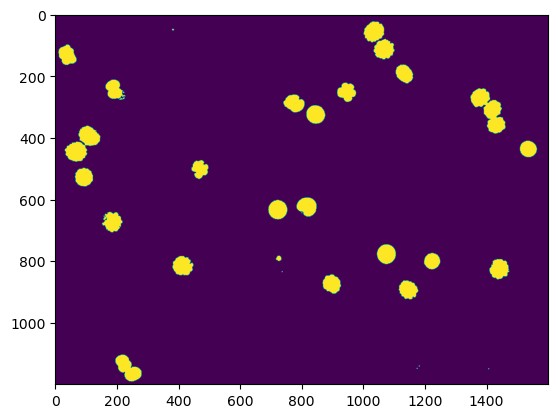

In [117]:
# 確認
path = "images/embryos.tif"
filled = preprocess(path, 35)
plt.imshow(filled)

Watershedによる領域分割  
複数の方法がある

In [ ]:
# まずEDMを作成
from scipy import ndimage as ndi
edm = ndi.distance_transform_edt(filled)
plt.imshow(edm)
edm.max()

In [ ]:
# local maximaの座標を得る
from skimage.feature import peak_local_max
max_coords = peak_local_max(edm, labels=filled, min_distance=30, threshold_abs = 10, # threshold_absがmaximaのしきい値
                            footprint=np.ones((5, 5))) # footprintの大きさでもmaximaの数は変化する
local_maxima = np.zeros_like(edm, dtype=bool)
local_maxima[tuple(max_coords.T)] = True

# local maximaを拡大して表示
local_maxima_dia= ndimage.binary_dilation(local_maxima, iterations= 5).astype(local_maxima.dtype)
plt.imshow(img_as_ubyte(local_maxima_dia))

In [ ]:
from skimage import segmentation
markers = ndi.label(local_maxima)[0]
labels = segmentation.watershed(-edm, markers, mask=filled)
plt.imshow(labels, cmap = "jet")
labels.max()

Watershed別法  
EDMにしきい値を設定して「確実な前景」を抽出し、それをマーカーとする

In [ ]:
# 確実に背景である領域を求める
# 対象（白）の領域を膨張させるということは、残った黒の背景は「確実に背景」
sure_bg = ndimage.binary_dilation(filled, iterations= 1).astype(filled.dtype)

# Finding sure foreground area
# 対象物が互いに接していなければ erosionして残った白い領域は確実に前景と言える
# 対象物が互いに接している場合、Euclidian Distance Map (EDM)を計算し、距離変換で得られた値の最大値✕ratio（可変）を閾値にして二値化することで、「確実な前景」が得られる
dist_transform = cv2.distanceTransform(filled, cv2.DIST_L2, 5)
ratio = 0.5
print("距離変換で得られた値の最小値と最大値:", dist_transform.min(), dist_transform.max())
print(f'閾値（距離変換で得られた値の最大値×{ratio}）:',ratio*dist_transform.min())
ret, sure_fg = cv2.threshold(dist_transform, ratio*dist_transform.max(),255,0)
plt.imshow(sure_fg)
print(sure_bg.dtype, sure_fg.dtype)

In [ ]:
# Finding unknown region
# 背景でも前景でもないunknownな領域の情報」を取得
# 「絶対に背景」から「絶対に前景」の情報を引く
sure_fg = np.uint8(sure_fg)
sure_bg = np.uint8(sure_bg)
unknown = cv2.subtract(sure_bg, sure_fg)
print(unknown.dtype)
plt.imshow(unknown*255)

In [ ]:
"""
Marker labelling
1. 明確な背景（sure background）情報
2. 明確な前景(sure foreground)情報
3. 背景でも前景でもないunknownな領域の情報
4. 1~3の情報に"ラベル"をつける
ｃｖ2.connectedComponents関数は画像の背景に0というラベルを与え，それ以外の物体に対して1から順にラベルをつけていく処理をする．
"""
ret, markers2 = cv2.connectedComponents(sure_fg)
# この時点での背景のピクセル値 -> 0、各オブジェクトのピクセル値 -> 1,2,...,37

# Add one to all labels so that sure background is not 0, but 1
markers2 = markers2+1
# この時点での背景のピクセル値 -> 1、各オブジェクトのピクセル値 -> 2,3,...,38

# # Now, mark the region of unknown with zero
# unknownのピクセル値を0にする
markers2[unknown == 1] = 0 # boolean indexing
# この時点での背景のピクセル値 -> 1、各オブジェクトのピクセル値 -> 2,3,...,38, unknownのピクセル値 -> 0
plt.imshow(markers2, cmap = "jet")

In [ ]:
# Watershed関数による処理
# markersの情報を元に処理、markersのラベルは更新され、境界領域のピクセル値は-1になる
embryo = cv2.cvtColor(filled, cv2.COLOR_GRAY2RGB) # 処理した2値画像に対して分割処理する、RGBに直す必要がある
markers2 = cv2.watershed(embryo, markers2) # imgはRGBである必要がある
# この時点での背景のピクセル値 -> 1、境界領域 -> -1, 各オブジェクト -> 2,3,...,38,
plt.imshow(markers2, cmap = "jet")
print(markers2.max())

In [ ]:
# 境界領域を赤色にする
embryo = cv2.imread("images/embryos.tif", 1)
embryo_segm = embryo.copy()
embryo_segm = cv2.cvtColor(embryo_segm, cv2.COLOR_BGR2RGB)
embryo_segm[markers2 == -1] = (255, 0, 0)
plt.imshow(embryo_segm)
cv2.imwrite("images/embryo_segm.png", embryo_segm)

後者のOpenCVの関数を使用して、EDMの2値化画像をマーカーとする方法が良さそうなので関数化  
`cv2.connectedComponentsWithStats()`関数を使用すると、ラベル化画像に加えて各領域の情報が取得できる
入力する画像はカラーの元画像img, モルフォロジー変換が完了した2値化画像 binary、EDMのしきい値 ratio
出力はラベル化した画像 markers（境界は-1, 背景は0, 対象は1, 2, 3,..）と元画像imgに境界線を重ねたimg_segm、stats, centroids

In [118]:
def watershed(img, binary, ratio = 0.5):

    sure_bg = ndimage.binary_dilation(binary, iterations= 1).astype(binary.dtype)
    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, ratio*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    sure_bg = np.uint8(sure_bg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(sure_fg)
    markers = markers+1
    markers[unknown == 1] = 0 # boolean indexing
    bin_rgb = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB) # 処理した2値画像に対して分割処理する、RGBに直す必要がある
    markers = cv2.watershed(bin_rgb, markers) # imgはRGBである必要がある

    img_segm = img.copy()
    # img_segm = cv2.cvtColor(img_segm, cv2.COLOR_BGR2RGB)
    img_segm[markers == -1] = (0, 0, 255) # 境界線を赤にする
              
    return markers, img_segm, stats, centroids

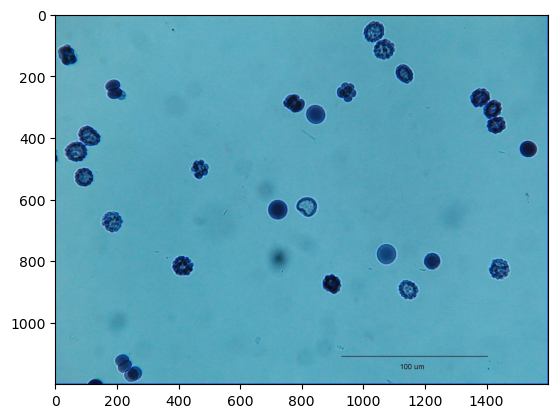

In [119]:
# 確認
embryo = cv2.imread("images/embryos.tif", 1)
markers, img_segm, stats, centroids = watershed(embryo, filled, 0.5)
plt.imshow(img_segm)

粒子解析  
作成したラベル画像を使用して、検出した対象の形態や輝度値を計測する  

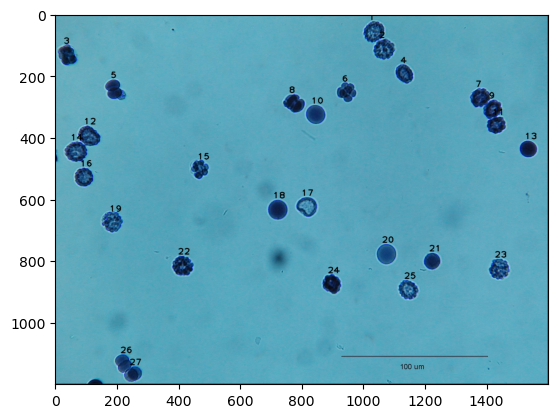

In [120]:
# statsには各ラベルごとの領域の情報が格納されている。[領域の左上のx座標, 領域の左上のy座標, 領域の幅, 領域の高さ, 面積]、stats[0]は背景の情報
# statsを利用して各領域をナンバリングした画像を作る
numbering = img_segm.copy()
for i in range(1, len(stats)):
    x, y, width, height, area = stats[i]  # このAreaは何を表している？
    cv2.putText(numbering, f"{i}", (x, y-20), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), 2, cv2.LINE_AA)
plt.imshow(numbering)

In [121]:
# ナンバリング画像を作る関数
def numbering(img_segm, stats):
    numbered_img = img_segm.copy()
    for i in range(1, stats.shape[0]):
        x, y, width, height, area = stats[i]  # このAreaは何を表している？
        cv2.putText(numbered_img, f"{i}", (x, y-20), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), 2, cv2.LINE_AA)
    return numbered_img

`skimage.measure.regionprops_table()`関数を使うと測定結果が辞書形式で返ってくる。Pandasのデータフレームで読み込めるので効率的。
引数propertiesで測定項目を指定する。引数extra_propertiesで独自の測定項目を計算する関数を入力することも可能。

In [122]:
from skimage import data, util
from skimage.measure import label, regionprops_table
embryo_gray = cv2.imread("images/embryos.tif", 0) # embryoのグレースケール画像について解析する、RGBでも可能
prop_dic = regionprops_table(markers, intensity_image = embryo_gray, properties=["label", "area", "image_intensity", "intensity_mean", "intensity_max", "axis_major_length", "axis_minor_length","perimeter", "solidity", "feret_diameter_max"])
data = pd.DataFrame(prop_dic)

In [123]:
data.head(16)# 0行目はバックグラウンドのデータ

,label,area,image_intensity,intensity_mean,intensity_max,axis_major_length,axis_minor_length,perimeter,solidity,feret_diameter_max
0,1,1839325,"[[160, 161, 163, 164, 164, 164, 164, 164, 164,...",164.798484,223.0,1840.945014,1389.051082,11235.989571,0.960782,1996.600361
1,2,3146,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",79.834393,180.0,67.523889,59.557156,223.137085,0.954490,70.000000
2,3,3038,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",75.987163,190.0,64.050539,60.885453,229.137085,0.932760,68.600292
3,4,2553,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",54.021543,126.0,65.850287,50.468439,199.923882,0.938948,66.610810
4,5,2350,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",65.745106,139.0,62.544044,47.953242,186.409163,0.971476,63.694584
5,6,2404,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",57.863977,126.0,66.099723,48.353839,216.101551,0.887085,71.344236
6,7,2461,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",64.773669,121.0,57.589173,56.174789,205.923882,0.921378,62.361847
7,8,2710,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",55.193358,130.0,62.531099,55.521963,204.651804,0.950544,65.368188
8,9,2630,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",48.071863,117.0,66.096077,51.483606,203.823376,0.951520,68.066144
9,10,2491,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",56.082296,162.0,62.021494,51.531924,197.687338,0.948230,65.253352


<class 'numpy.ndarray'>
(2646,)


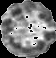

In [62]:
show(data.iloc[16, 2]*2) # 変数image_intensityには各領域に対応する、intensity_imageの画像が入っている

<class 'numpy.ndarray'>
(2113,)


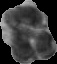

In [63]:
show(data["image_intensity"][3]*1.5)

In [64]:
# 以下のImageJ/FIJIにおけるShape descriptorsのうち、真円度、アスペクト比、円形度は計算で求める：
# 真円度 Circularity = 4π×[Area]/[Perimeter]2
# アスペクト比 Aspect ratio = Major axis/Minor axis
# 円形度 Roundness, アスペクト比の逆数
# 凸度 Solidity = [Area]/[Convex area]

In [65]:
data["Circularity"] = (4*np.pi * data.area)/(data.perimeter)**2
data["aspect_ratio"] = data.axis_major_length/data.axis_minor_length
data["Roundness"] = 1/data.aspect_ratio

In [69]:
# データを解析した日付とファイル名を表す変数を追加
date = "2023-08-01"
import os
filename = os.path.basename(path)
data["Date"] = date
data["File"] = filename

In [70]:
data.head()

,label,area,image_intensity,intensity_mean,intensity_max,axis_major_length,axis_minor_length,perimeter,solidity,feret_diameter_max,Circularity,aspect_ratio,Roundness,Date,File
0,1,1839325,"[[160, 161, 163, 164, 164, 164, 164, 164, 164,...",164.798484,223.0,1840.945014,1389.051082,11235.989571,0.960782,1996.600361,0.183082,1.325326,0.754532,2023-08-01,embryos.tif
1,2,3146,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",79.834393,180.0,67.523889,59.557156,223.137085,0.954490,70.000000,0.794008,1.133766,0.882016,2023-08-01,embryos.tif
2,3,3038,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",75.987163,190.0,64.050539,60.885453,229.137085,0.932760,68.600292,0.727121,1.051984,0.950585,2023-08-01,embryos.tif
3,4,2553,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",54.021543,126.0,65.850287,50.468439,199.923882,0.938948,66.610810,0.802659,1.304782,0.766412,2023-08-01,embryos.tif
4,5,2350,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",65.745106,139.0,62.544044,47.953242,186.409163,0.971476,63.694584,0.849852,1.304271,0.766712,2023-08-01,embryos.tif


In [71]:
# データを並べかえ
data = data.iloc[:, [0,13, 14, 1,3,4,7,8,9,10,11,12,5,6,2]]

In [73]:
data.head()

,label,Date,File,area,intensity_mean,intensity_max,perimeter,solidity,feret_diameter_max,Circularity,aspect_ratio,Roundness,axis_major_length,axis_minor_length,image_intensity
0,1,2023-08-01,embryos.tif,1839325,164.798484,223.0,11235.989571,0.960782,1996.600361,0.183082,1.325326,0.754532,1840.945014,1389.051082,"[[160, 161, 163, 164, 164, 164, 164, 164, 164,..."
1,2,2023-08-01,embryos.tif,3146,79.834393,180.0,223.137085,0.954490,70.000000,0.794008,1.133766,0.882016,67.523889,59.557156,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,2023-08-01,embryos.tif,3038,75.987163,190.0,229.137085,0.932760,68.600292,0.727121,1.051984,0.950585,64.050539,60.885453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,4,2023-08-01,embryos.tif,2553,54.021543,126.0,199.923882,0.938948,66.610810,0.802659,1.304782,0.766412,65.850287,50.468439,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,5,2023-08-01,embryos.tif,2350,65.745106,139.0,186.409163,0.971476,63.694584,0.849852,1.304271,0.766712,62.544044,47.953242,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [81]:
# 粒子解析してデータフレームを作る関数
def analyze_particles(markers, intensity_image, path, date = "2023-08-01"):
    prop_dic = regionprops_table(markers, intensity_image = intensity_image, properties=["label", "area", "image_intensity", "intensity_mean", "intensity_max", "axis_major_length", "axis_minor_length","perimeter", "solidity", "feret_diameter_max"])
    data = pd.DataFrame(prop_dic)
    data["Circularity"] = (4*np.pi * data.area)/(data.perimeter)**2
    data["aspect_ratio"] = data.axis_major_length/data.axis_minor_length
    data["Roundness"] = 1/data.aspect_ratio
    filename = os.path.basename(path)
    data["Date"] = date
    data["File"] = filename
    data = data.iloc[:, [0,13, 14, 1,3,4,7,8,9,10,11,12,5,6,2]]
    return data

In [74]:
# データをcsv形式あるいはexcel形式で保存
# "Image intensity"のデータは正しく保存されない
data.to_csv("embryo_data.csv")
data.to_excel("embryo_data.xlsx")

In [106]:
%%timeit -r 3 -n 1
# 画像を読み込んでからcsvファイルを保存するまでの時間を計測
path = "images/embryos.tif"
img = cv2.imread("images/embryos.tif", 1)
img_gray = cv2.imread("images/embryos.tif", 0)
radius = 35
ratio = 0.5
date = "2023-08-01"

filled = preprocess(path, radius)
markers, img_segm, stats, centroids = watershed(img, filled, ratio)
img_numbered = numbering(img_segm, stats)
analyze_particles(markers, img_gray, path, date)

cv2.imwrite("embryo_numbered.png", img_numbered)
data.to_csv("embryo_data.csv")
data.to_excel("embryo_data.xlsx")

18.9 s ± 51.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
